# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/bias1/"

Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
deep: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
# bias 
opes: OPES_METAD ARG=deep.node-0,deep.node-1 TEMP=300 PACE=500 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

Text(0, 0.5, '$\\psi$')

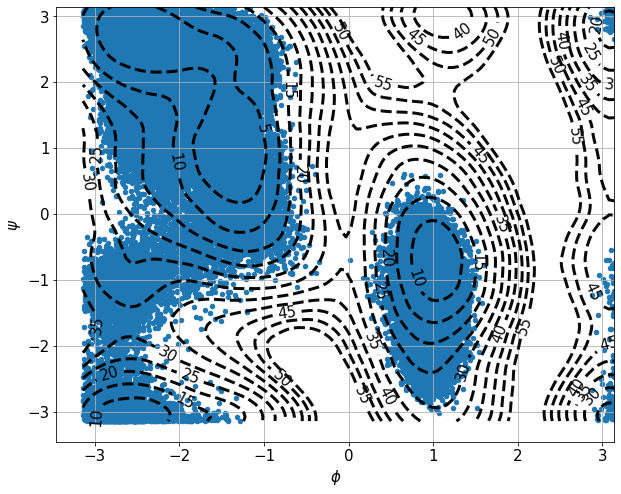

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

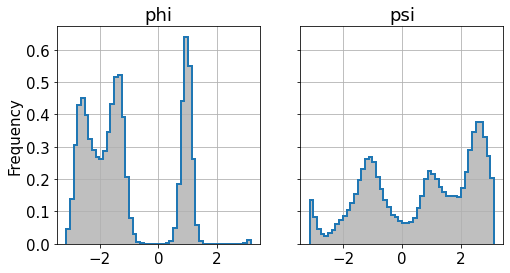

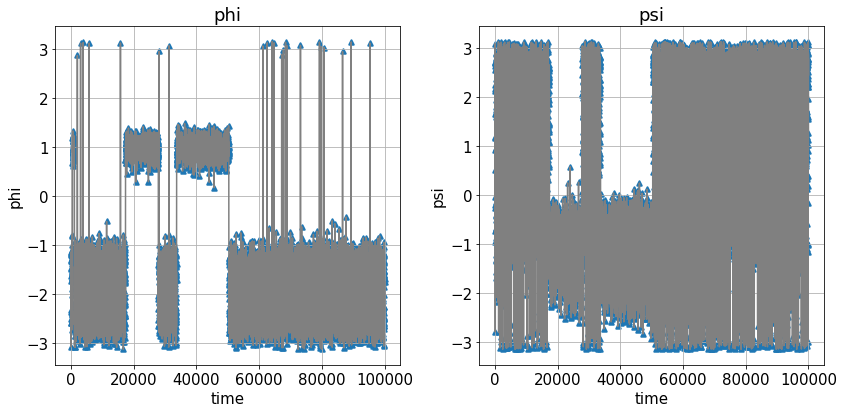

In [10]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

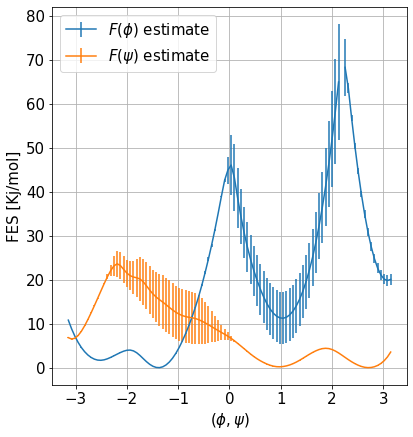

In [11]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

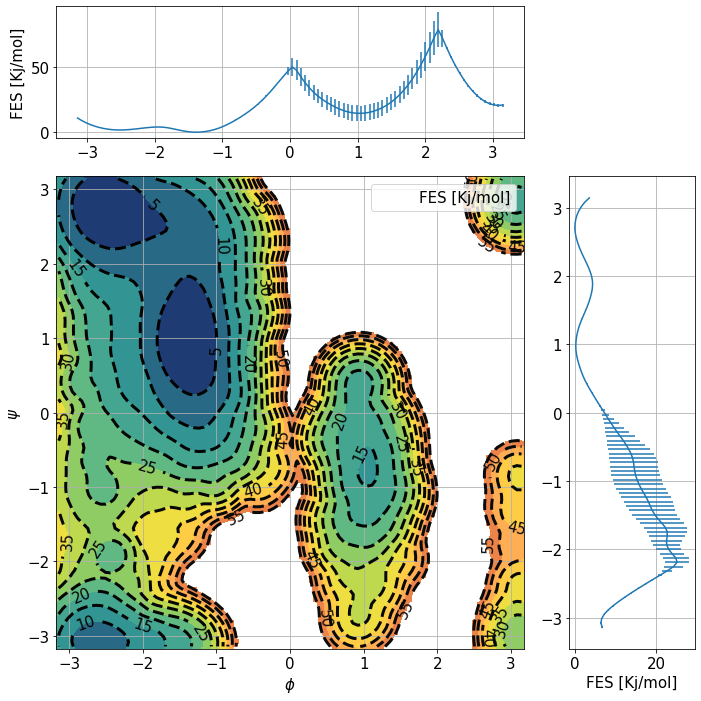

In [12]:
gridspec_fes(s,logweight,sim_parameters)

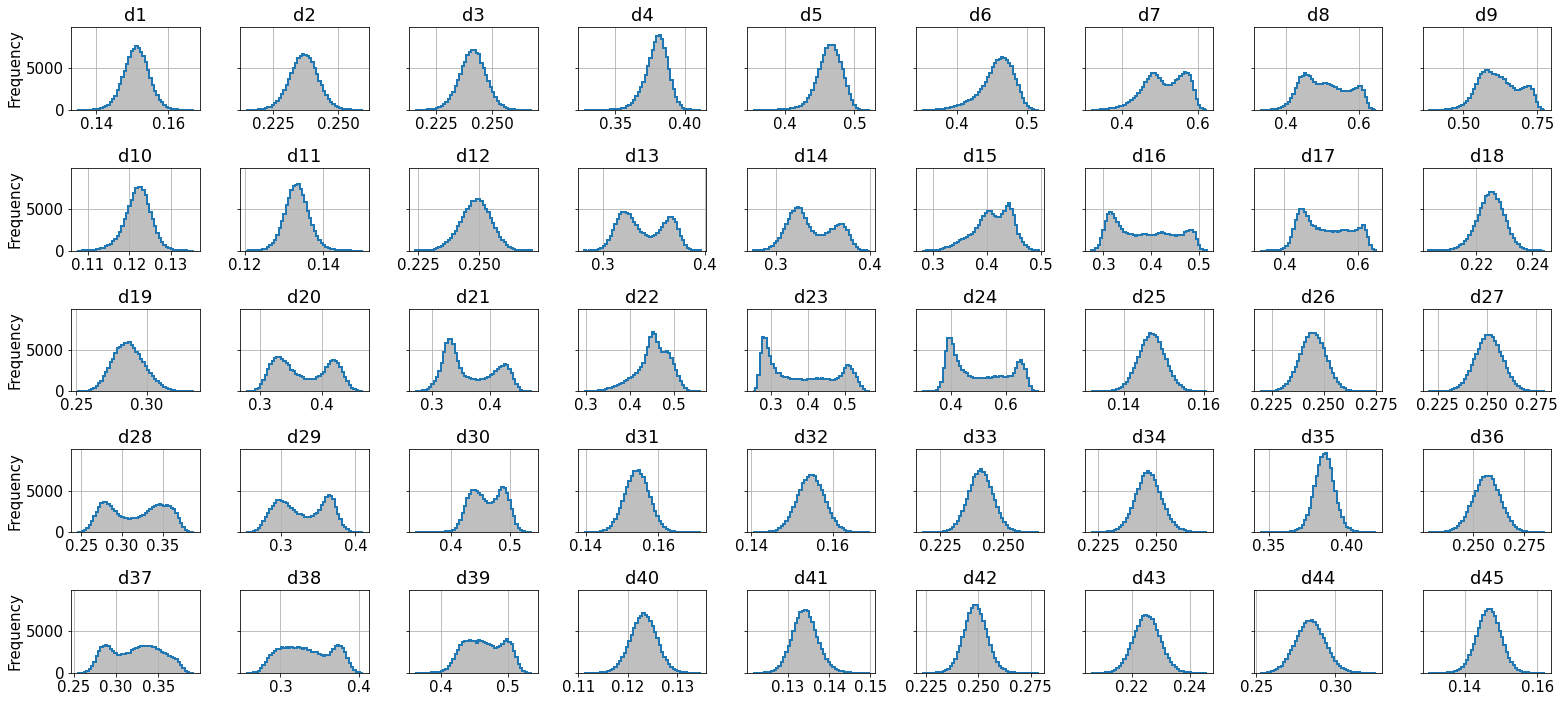

In [13]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

In [14]:
#-- compile cpp, longest procedure --#
execute("make",folder=folder)
#-- remove old files
#execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=folder, print_result=False)

#-- write input file to create time lagged dataset --#
path = "COLVAR"
names = load_dataframe(folder+path).filter(regex="^d[^a-z]").columns
first_index = data.columns.get_loc(names[0])
last_index = data.columns.get_loc(names[-1])
weights_index = data.columns.get_loc("opes.bias")
skip = 4 #skip the first four rows after the header 
with open(folder+"input.dat","w") as file:
    print("""colvar = """+path+"""
skip_rows = """+str(skip)+"""
beta = """+str(sim_parameters["beta"])+"""
lag = 1
first_index = """+str(first_index)+"""
last_index = """+str(last_index)+"""
if_weights = 1
weights_index = """+str(weights_index)+"""
""",file=file)

Completed: make


In [15]:
def my_autocorrelation_cpp_all(inputFile,lag,path="./",weight=True):
    
    #-- modify lag time in input file --#
    execute("sed -i 's/lag.*/lag = "+str(lag)+"/g' "+inputFile,folder=path, print_result=False)

    #-- modify if_weight in input file --#
    if not weight:
        execute("sed -i 's/if_weights.*/if_weights = 0/g' "+inputFile,folder=path, print_result=False)
    else:
        execute("sed -i 's/if_weights.*/if_weights = 1/g' "+inputFile,folder=path, print_result=False)

    data = create_time_lagged_dataset_cpp(inputFile,path=path)
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]),np.array(data[:][1]),np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.array([ np.average(x_t.T[i],weights=w_t) for i in range(x_t.shape[1]) ])
    variance = np.array([ np.cov(x_t.T[i],aweights=w_t) for i in range(x_t.shape[1]) ])
    autocorr = np.array([np.sum( np.multiply(np.multiply((x_t.T[i]-mean[i]),(x_lag.T[i]-mean[i])),w_lag))/(Nw*variance[i]) for i in range(x_t.shape[1])])
    
    return autocorr

In [16]:
#-- slow way, one descriptor at once --#
'''
last=70
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = my_autocorrelation_cpp("input.dat",lag=i,index=k,path=folder,weight=True)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1
'''

'\nlast=70\nx = np.linspace(0,last+1,last)\nacorr = np.empty(last)\ntimescale = np.empty(len(descriptors_names))\nk=0\nfor desc in descriptors_names:\n    print("autocorrelation for ", desc)\n    for i in range(last):\n        acorr[i] = my_autocorrelation_cpp("input.dat",lag=i,index=k,path=folder,weight=True)\n    axs[0].plot(x,acorr)\n    timescale[k] = integrate.trapz(acorr[:last],x[:last])\n    k+=1\n'

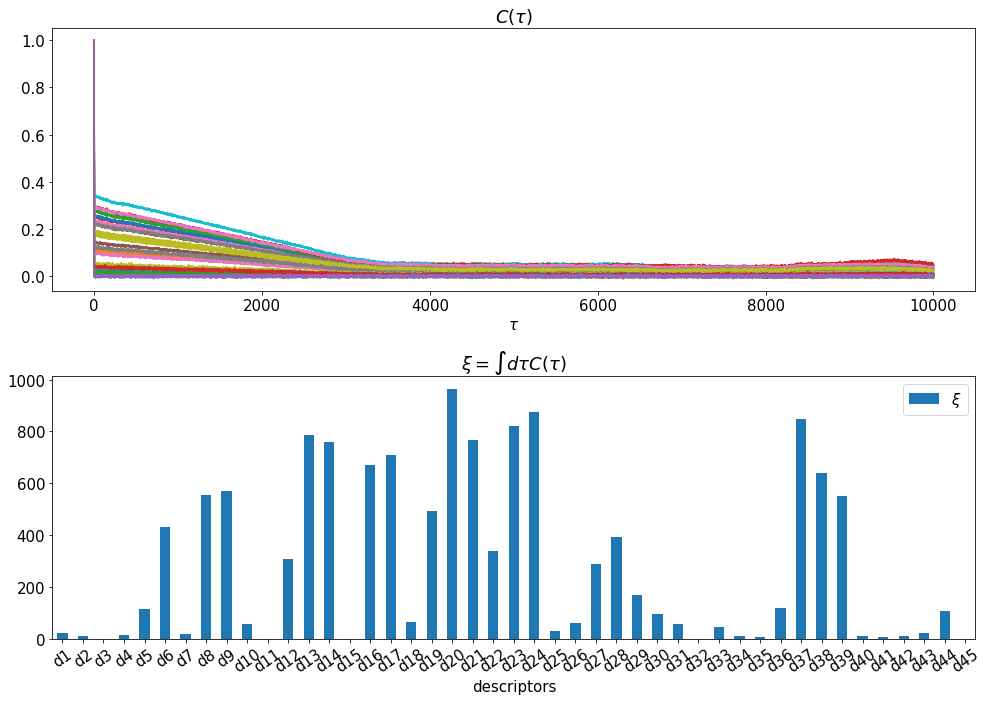

964.4272975608071
0.8540528052883279


In [34]:
#-- fast way, one descriptor at once --#
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
last=10000
x = np.linspace(0,last+1,last)
acorr = np.array( [my_autocorrelation_cpp_all("input.dat",lag=i,path=folder,weight=True) for i in range(last)] )
timescale = np.empty(len(descriptors_names))

for k in range(len(descriptors_names)):
    corr = acorr.T[k]
    axs[0].plot(x,corr)
    timescale[k] = integrate.trapz(corr[:last],x[:last])

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

In [35]:
np.savetxt("acorr.txt",acorr)

In [5]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,#10 ok
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": True,
              "cpp": False,
              }
#--------------------------------------#

## check for which lag time the gap is maximum 

In [6]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,25]
time = []
seeds = [21,151,500]
for seed in seeds:
    timescale = np.empty(len(lags))
    for i,lag in enumerate(lags):
        train_parameters["lag_time"] = lag
        torch.manual_seed(seed)
        model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

        #-- move the model back to cpu for convenience --# 
        model.to('cpu')
        #-- save gap between eigenvalues
        timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
    time.append(timescale)

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.131      -1.133      0.955  0.175  
100   -1.155      -1.155      0.971  0.183  
150   -1.169      -1.167      0.979  0.189  
200   -1.340      -1.332      0.961  0.374  
250   -1.447      -1.438      0.981  0.464  
300   -1.484      -1.472      0.984  0.498  
350   -1.501      -1.487      0.986  0.513  
400   -1.510      -1.495      0.988  0.519  
INFO: Early stopping
426   -1.513      -1.498      0.989  0.524  
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.088      -1.099      0.946  0.136  
100   -1.142      -1.156      0.959  0.182  
150   -1.257      -1.289      0.970  0.289  
200   -1.295      -1.324      0.979  0.314  
250   -1.302      -1.329      0.982  0.322  
INFO: Early stopping
287   -1.312      -1.340      0.984  0.328  
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.965      -0.971      0.954  0.010  
100   -1.045      -1.042      0.962  0.080  
150   -1.113      -1.112    

[0.46500021 0.65587008 0.77728438 0.84177983 0.89189482 0.90896684
 0.94317722 0.94064391 0.94548535 0.96796227 0.95274913 0.94259208
 0.96414208 0.94023103 0.9538691  0.95635456 0.94686615]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 25]


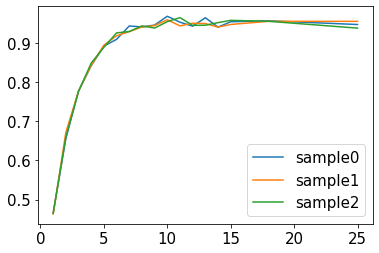

In [7]:
#-- plot results --#
for j,el in enumerate(time):
    plt.plot(lags,el,label="sample"+str(j))
plt.legend()
print(time[0])
print(lags)

## DeepTICA Analysis and Export

In [38]:
torch.manual_seed(21)
train_parameters["lag_time"] = 100 #10 massimo
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.937      -0.936      0.920  0.016  
100   -0.962      -0.959      0.941  0.020  
150   -0.971      -0.960      0.947  0.025  
200   -0.977      -0.959      0.949  0.028  
INFO: Early stopping
210   -0.979      -0.959      0.950  0.029  
already exists
model saved
timescales:  [1939.0469    28.28258]
eigenvalues:  [0.9497355  0.02913703]
gap:  0.9205985


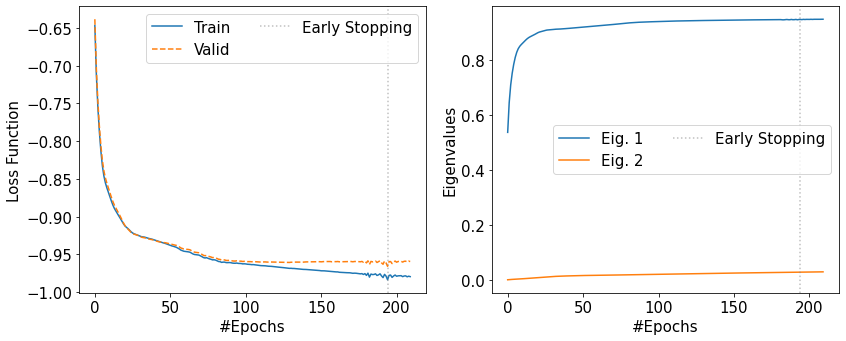

In [39]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [40]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

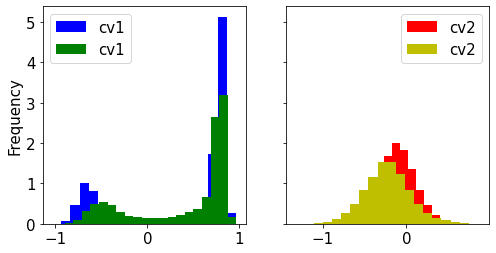

In [41]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

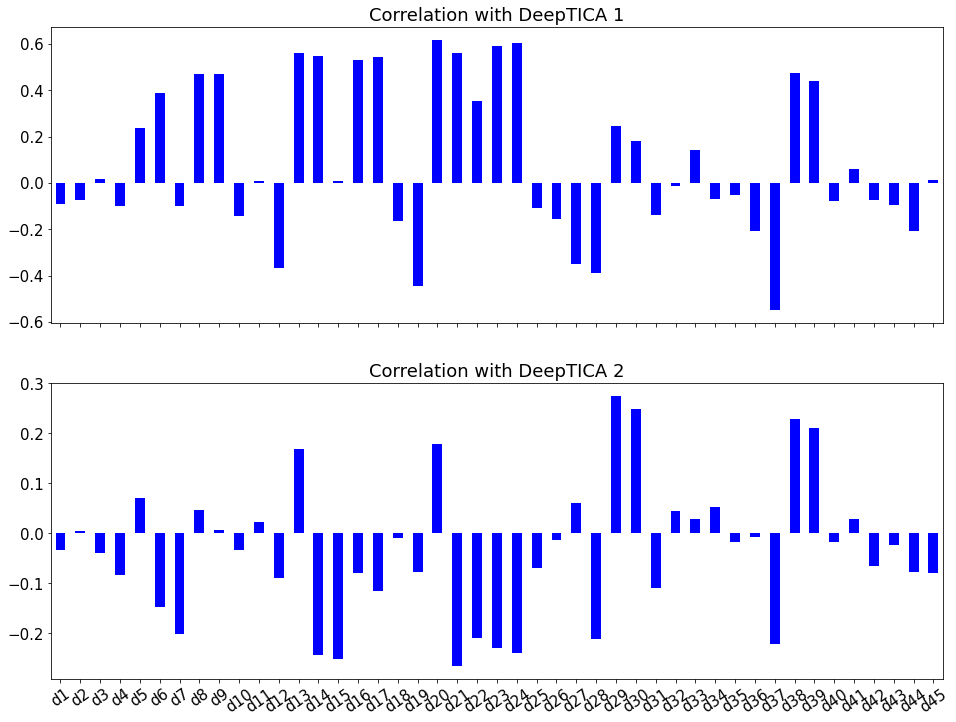

In [24]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

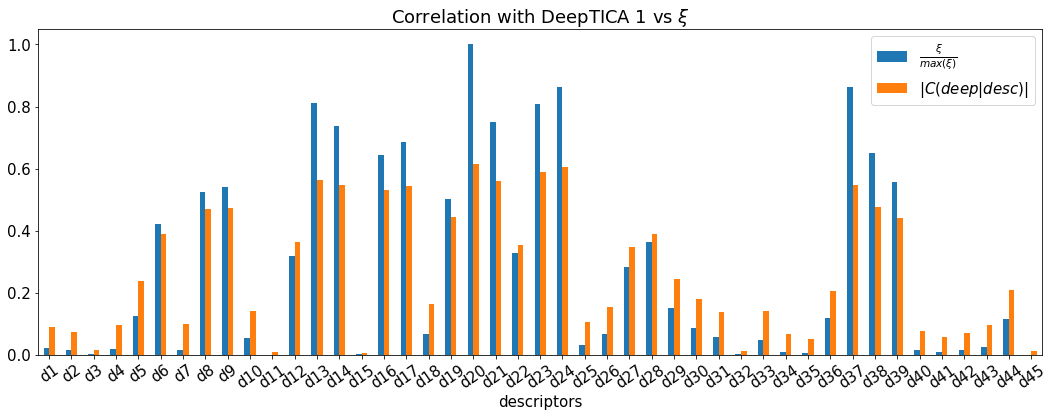

In [25]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### FES estimate from new cvs   

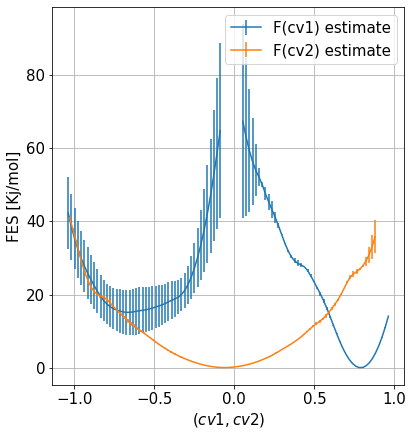

In [42]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight = np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]
logweight = logweight - np.max(logweight)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### FES estimate from old cvs  

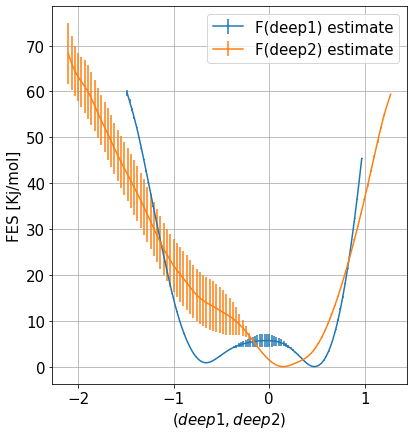

In [27]:
s = data.filter(regex="^deep.node-").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(deep1) estimate","F(deep2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(deep1,deep2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

In [14]:
#plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)

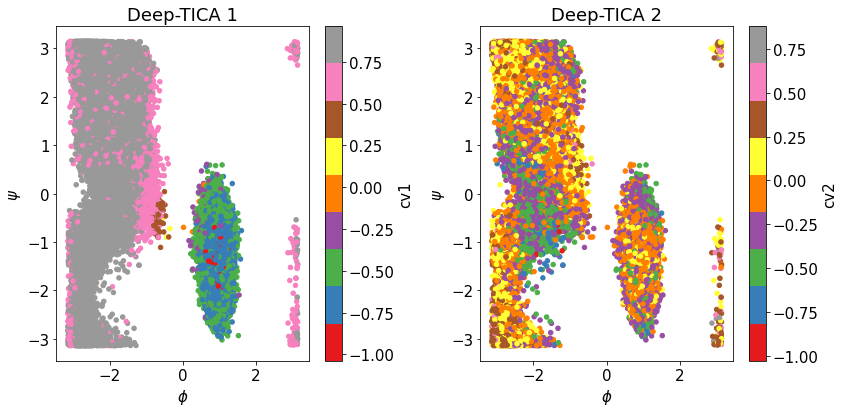

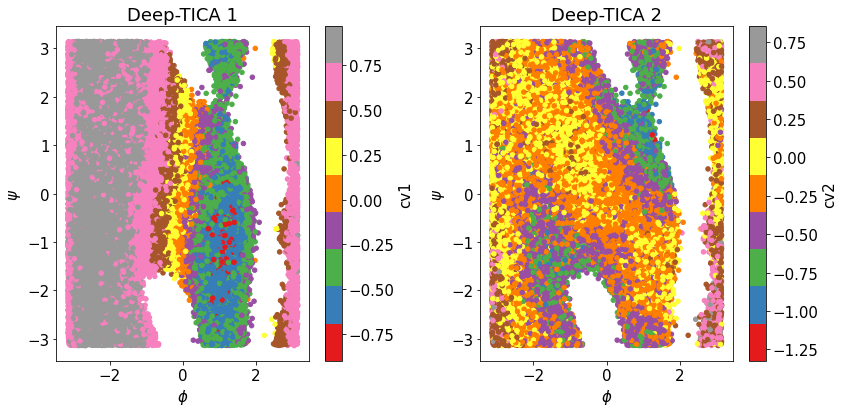

In [43]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [16]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

0.0028028030475623867

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [17]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X,logweight=logweight)
prod = np.multiply(np.multiply(cv1,np.exp(logweight)),new_cv2).mean()
print(prod)

-2.0269323806234272e-11


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

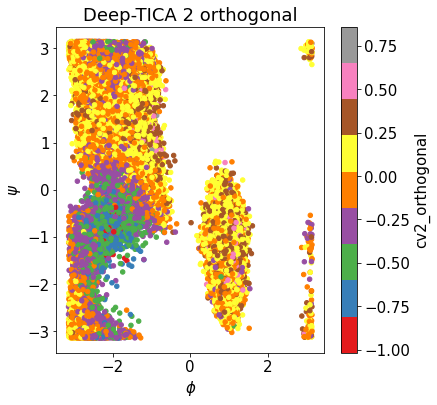

In [18]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="psi",x="phi",c="cv2_orthogonal",cmap="Set1",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
ax.set_title('Deep-TICA 2 orthogonal')

## $\Delta F$ Estimate

Text(0.5, -0.03, 'shadow error of 1KbT')

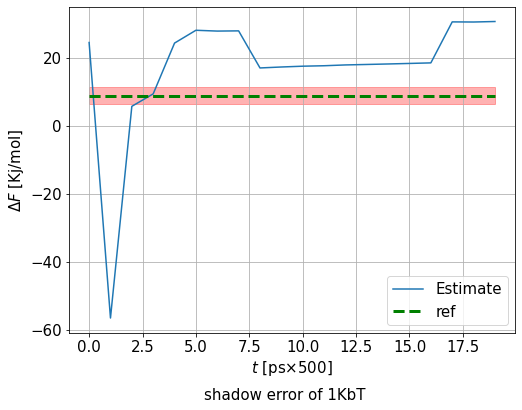

In [19]:
res = 8.92808817900219
#-- each step is 1ps --#
#-- we are interested in the first 10 ns --#
last = 1*1000*10 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^phi").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))*sim_parameters["beta"]
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=500

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) 
    ind2 = (grid>0) 
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)
    
    deltaf = np.append(deltaf,(1/sim_parameters["beta"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),1*kb*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [Kj/mol]")
txt = "shadow error of 1KbT"
# center text
fig.text(.5, -.03, txt, ha='center')